In [1]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
import math
from math import *
import copy

In [2]:
# fetching the data and get top categories data
data_set = fetch_20newsgroups(subset='all')
names = list(data_set.target_names)
categorized_data = {}
for idx in data_set.target:
    if names[idx] in categorized_data:
        categorized_data[names[idx]] += 1
    else:
        categorized_data[names[idx]] = 1

top_categories = sorted(categorized_data, key=categorized_data.__getitem__, reverse=True)[:10]
top_data = fetch_20newsgroups(subset='all', categories=top_categories)

In [132]:
# get the original labels of the data
original_labels = top_data.target

In [144]:
# TFIDF vectorization on the top data
tfidf_vectorizer = TfidfVectorizer(max_df = 0.5, max_features = 1000, min_df = 2, stop_words = 'english', use_idf = True)
tfidf_vectorized = tfidf_vectorizer.fit_transform(top_data.data)
word_vectorized = tfidf_vectorized.toarray()

In [4]:
# for choosing k number of centroids from given dataset randomly
def choose_random_centroids(data, k):
    n_samples, n_features = np.shape(data)
    centroids = np.zeros((k, n_features))
    for i in range(k):
        centroid = data[np.random.choice(range(n_samples))]
        centroids[i] = centroid
    return centroids

In [5]:
# calculates euclidean distance between 2 vectors
def calculate_euclidean_distance(x1, x2):
    distance = 0
    for i in range(len(x1)):
        distance += pow((x1[i] - x2[i]), 2)
    return distance

In [6]:
# determines the nearest centroid for a sample data point
def find_nearest_centroid(sample, centroids):
    nearest_cent = 0
    nearest_dist = float('inf')
    for i, centroid in enumerate(centroids):
        distance = calculate_euclidean_distance(sample, centroid)
        if distance < nearest_dist:
            nearest_cent = i
            nearest_dist = distance
    return nearest_cent

In [7]:
# creating clusters assigning the data points to it nearest centroids
def create_clusters(centroids, data, k):
    n_samples = np.shape(data)[0]
    clusters = []
    for i in range(k):
        clusters.append([])
    for sample_i, sample in enumerate(data):
        centroid_i = find_nearest_centroid(sample, centroids)
        clusters[centroid_i].append(sample_i)
    return clusters

In [8]:
# calculate the centroids of a given cluster by taking its mean
def calculate_centroids(clusters, data, num_k):
    features = np.shape(data)[1]
    centroids = np.zeros((num_k, features))
    for idx, cluster in enumerate(clusters):
        centroid = np.mean(data[cluster], axis=0)
        centroids[idx] = centroid
    return centroids

In [9]:
# assign lables to the points of the clusters
def get_cluster_labels(clusters, data):
    y_pred = np.zeros(np.shape(data)[0])
    for cluster_i, cluster in enumerate(clusters):
        for sample_i in cluster:
            y_pred[sample_i] = cluster_i
    return y_pred

In [10]:
# applying k-means on a given dataset
def apply_k_means(data, num_k, max_iter):
    centroids = choose_random_centroids(data, num_k)
    for iter in range(max_iter):
        clusters = create_clusters(centroids, data, num_k)
        prev_centroids = centroids
        centroids = calculate_centroids(clusters, data, num_k)
        difference = centroids - prev_centroids

        if not difference.any():
            break
    return get_cluster_labels(clusters, data), centroids, clusters

# Bisecting k-Means

In [11]:
"""Calculate SSE for a single cluster"""
def calculate_single_sse(data, centroids):
    sse = 0
    for item in range(len(data)):
        sse += calculate_euclidean_distance(data[item], centroids)
    return sse

In [83]:
"""
At first it applies basic k-mean on the given data and calculates sse of the two clusters. Clusters with the larger sse is then selected for further bisection. It iteratively
bisects the cluster before number of clusters becomes equal to k
"""
def bisecting_kmeans(data, num_k):
    data_clusters_list = []
    predicted_labels, centroids, clusters = apply_k_means(data, 2, 100)
    bisected_clusters = [[] for i in range(len(clusters))]
    for cluster_i, cluster in enumerate(clusters):
        for sample_i in cluster:
            bisected_clusters[cluster_i].append(data[sample_i])
    for i in range(len(clusters)):
        data_clusters = {}
        data_clusters['sse'] = calculate_single_sse(bisected_clusters[i], centroids[i])
        data_clusters['cluster'] = bisected_clusters[i]
        data_clusters['cluster_idx'] = clusters[i]
        
        data_clusters_list.append(data_clusters)
    
    if num_k == 2:
        return data_clusters_list
    else:
        while len(data_clusters_list) != num_k:
            data_clusters_list = sorted(data_clusters_list, key=lambda k: k['sse'], reverse=True)
            selected_data = np.array(data_clusters_list[0]['cluster'])
            data_clusters_list = data_clusters_list[1:]
            predicted_labels, centroids, clusters = apply_k_means(selected_data, 2, 30) 
            bisected_clusters = [[] for i in range(len(clusters))]
            for cluster_i, cluster in enumerate(clusters):
                for sample_i in cluster:
                    bisected_clusters[cluster_i].append(data[sample_i])
                    
            for i in range(len(clusters)):
                data_clusters = {}
                data_clusters['sse'] = calculate_single_sse(bisected_clusters[i], centroids[i])
                data_clusters['cluster'] = bisected_clusters[i]
                data_clusters['cluster_idx'] = clusters[i]
                data_clusters_list.append(data_clusters)
                
        return data_clusters_list

In [114]:
def total_sse(cl):
    total_sse = 0
    for item in cl:
        total_sse += item['sse']
    return total_sse

In [150]:
"""
Calcultaes entropy of the clustering. First it creates distribution of classes for each cluster, then it clacultaes entropy for each cluster summing up the probability of
each class mulitplied by the log of the that probability. Finally the weighted average of the entropy over the clusters is measured. 
"""
def calculate_entropy(original_label, predicted_lables, num_k):
    unique_labels, counts_labels = np.unique(original_label, return_counts=True)
    original_label_count = dict.fromkeys(unique_labels, 0)
    label_count_list = [copy.deepcopy(original_label_count) for i in range(num_k)]
    total_data = len(original_label)

    for idx in range(len(predicted_lables)):
        label_count_list[int(predicted_lables[idx])][int(original_label[idx])] += 1

    total_entropy = 0
    for item in label_count_list:
        cluster_entropy = 0
        weighted_entropy = 0
        item_sum = sum(item.values())
        for key, value in item.items():
            try:
                div_value = float(value / item_sum)
            except Exception as e:
                div_value = 0
            try:
                log_value = log(div_value, 2)
            except Exception as e:
                log_value = 0
            mul_value = (-1) * div_value * log_value
            cluster_entropy += mul_value
        weighted_entropy = cluster_entropy * (item_sum / total_data)
        total_entropy += weighted_entropy

    return total_entropy

In [151]:
"""Calculate the total entropy of the clusters after a single run"""
def total_entropy(cl, original_labels, word_vectorized, num_k):
    predicted_label = [0 for i in range(word_vectorized.shape[0])]
    k = 0
    for item in cl:
        idx = item['cluster_idx']
        for id in idx:
            predicted_label[id] = k
        k += 1
    return calculate_entropy(original_labels, predicted_label, num_k)

for k= 2 completed
9426.997337384362 3.166757024516361
for k= 4 completed
9520.522484805118 3.082573532998377
for k= 6 completed
9667.939717771369 3.31970352057228
for k= 8 completed
9571.693140521362 3.052182764631826
for k= 10 completed
9755.663475617102 3.317327204337394
for k= 12 completed
9595.799024551063 3.3165720301402333
for k= 14 completed
9577.410673019916 3.3150873129688017
for k= 16 completed
9648.676731325138 3.3106541826169193


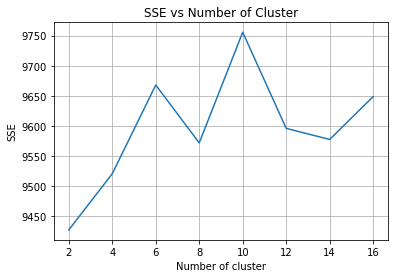

In [153]:
sse_score_or = {}
entropy_sc = {}
for k in range(2, 18, 2):
    cluster_set = bisecting_kmeans(word_vectorized, k)
    sse_score_or[k] = total_sse(cluster_set)
    entropy_sc[k] = total_entropy(cluster_set, original_labels, word_vectorized, k)
    print("for k= " + str(k) + " completed")
    print(sse_score_or[k], entropy_sc[k])

plt.figure()
plt.plot(list(sse_score_or.keys()), list(sse_score_or.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.title("SSE vs Number of Cluster")
plt.grid(True)
plt.show()

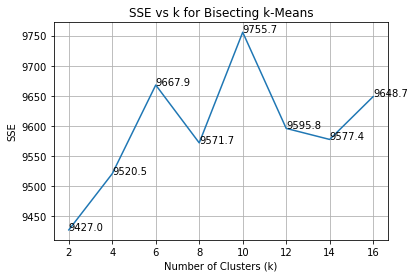

In [157]:
fig, ax = plt.subplots()
ax.plot(list(sse_score_or.keys()), list(sse_score_or.values()))
ax.set_xlabel("Number of Clusters (k)")
ax.set_ylabel("SSE")
ax.set_title("SSE vs k for Bisecting k-Means")
for i, txt in enumerate(sse_score_or.values()):
    ax.annotate("{0:.1f}".format(txt), (list(sse_score_or.keys())[i], list(sse_score_or.values())[i]))
plt.grid(True)
plt.show()

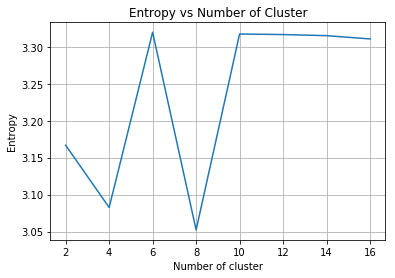

In [154]:
plt.figure()
plt.plot(list(entropy_sc.keys()), list(entropy_sc.values()))
plt.xlabel("Number of cluster")
plt.ylabel("Entropy")
plt.title("Entropy vs Number of Cluster")
plt.grid(True)
plt.show()

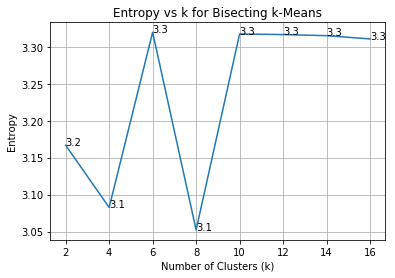

In [155]:
fig, ax = plt.subplots()
ax.plot(list(entropy_sc.keys()), list(entropy_sc.values()))
ax.set_xlabel("Number of Clusters (k)")
ax.set_ylabel("Entropy")
ax.set_title("Entropy vs k for Bisecting k-Means")
for i, txt in enumerate(entropy_sc.values()):
    ax.annotate("{0:.1f}".format(txt), (list(entropy_sc.keys())[i], list(entropy_sc.values())[i]))
plt.grid(True)
plt.show()